# Basic data access 
This notebook showcases helper functions from `climakitae` that enable you to access and export the AE catalog data, while also allowing you to perform spatial subsetting and view the data options in an easy-to-use fashion. These functions could be easily implemented in a python script.

**Runtime**: < 1 min

In [35]:
import pandas as pd
import xarray as xr

import climakitae as ck 

## High-level details 
The AE data catalog has many different types of data. Our helper library `climakitae` attempts to make accessing and retrieving this data intuitive, as well as simplify climate and statistical analysis with the data down the line, by performing some data transformations as the data is retrieved.<br><br> To retrieve the data, you'll need to make some selections as to your climate variable, data resolution, location settings, and many other options. There are also several high-level options you'll need to set when selecting your data, detailed below: 

### Data type: Gridded or Stations
**Gridded**: Gridded (i.e. raster) climate data at various spatial resolutions.<br><br>
**Stations**: Gridded (i.e. raster) climate data at unique grid cell(s) corresponding to the central coordinates of the selected weather station(s). 
- This data is bias-corrected (i.e localized) to the exact location of the weather station using the historical in-situ data from the weather station(s). 
- This data is currently only available for dynamically downscaled air temperature data. 

### Scientific approach: Time or Warming Level
**Time**: Retrieve the data using a traditional time-based approach that allows you to select historical data, future projections, or both, along with a time-slice of interest. 
- “Historical Climate” includes data from 1980-2014 simulated from the same GCMs used to produce the Shared Socioeconomic Pathways (SSPs). It will be automatically appended to a SSP time series when both are selected. Because this historical data is obtained through simulations, it represents average weather during the historical period and is not meant to capture historical timeseries as they occurred.
- “Historical Reconstruction” provides a reference downscaled [reanalysis](https://www.ecmwf.int/en/about/media-centre/focus/2020/fact-sheet-reanalysis) dataset based on atmospheric models fit to satellite and station observations, and as a result will reflect observed historical time-evolution of the weather.
- Future projections are available for [greenhouse gas emission scenario (Shared Socioeconomic Pathway, or SSP)](https://climatescenarios.org/primer/socioeconomic-development) SSP 3-7.0 through 2100 with the dynamically-downscaled General Circulation Models (GCMs).
     - One GCM was additionally downscaled for two additional SSPs (SSP 5-8.5 and SSP 2-4.5)<br>

**Warming Level**: Retrieve the data by future global warming levels, which will automatically retrieve all available model data for the historical+future period and then calculate the time window around which each simulation reaches the selected warming level.  
- Because warming levels are defined based on amount of global mean temperature change, they can be used to compare possible outcomes across multiple scenarios or model simulations.
- This approach includes all simulations that reach a specified amount of warming regardless of when they reach that level of warming, rather than the time-based approach, which will preliminarily subset a portion of simulations that follow a given SSP trajectory.
    
### Downscaling method: Dynamical, Statistical, or both
**Dynamical**: [Dynamically downscaled](https://dept.atmos.ucla.edu/alexhall/downscaling-cmip6) WRF data, produced at hourly intervals. If you select 'daily' or 'monthly' for 'Timescale', you will receive an average of the hourly data. The spatial resolution options, on the other hand, are each the output of a different simulation, nesting to higher resolution over smaller areas.<br><br>
**Statistical**: [Hybrid-statistically downscaled](https://loca.ucsd.edu) LOCA2-Hybrid data, available at daily and monthly timescales. Multiple LOCA2-Hybrid simulations are available (100+) at a fine spatial resolution of 3km.

## See the options in our data catalog
The interface provides several methods to explore available data options. You can get a comprehensive overview or explore step by step.

In [4]:
# Initialize the interface
cd = ck.ClimateData()


2025-12-18 16:22:24 - climakitae.new_core.user_interface - INFO - Initializing ClimateData interface
2025-12-18 16:22:24 - climakitae.new_core.dataset_factory - INFO - DatasetFactory initialized with 2 validators and 10 processors
2025-12-18 16:22:24 - climakitae.new_core.user_interface - INFO - ClimateData initialization successful
2025-12-18 16:22:24 - climakitae.new_core.user_interface - INFO - ✅ Ready to query!


In [ ]:

# Get a comprehensive overview of all available options
cd.show_all_options()

# Or you can see specific categories by uncommenting any of the lines below:
# cd.show_catalog_options()
# cd.show_activity_id_options()
# cd.show_institution_id_options()
# cd.show_source_id_options()
# cd.show_experiment_id_options()
# cd.show_table_id_options()
# cd.show_grid_label_options()
# cd.show_variable_options()
# cd.show_installation_options()
# cd.show_processors()
# cd.show_boundary_options()
# cd.show_station_options()

# this will be explored in more detail in the next section

## See the data options for a particular subset of inputs
You can explore options step by step, building your query as you learn about available data.

In [ ]:
# Explore options step by step
print("=== Available Catalogs ===")
cd.show_catalog_options()

print("\n=== Choose 'renewable energy generation' catalog and explore installations ===")
renewables_explorer = cd.catalog("renewable energy generation")
renewables_explorer.show_installation_options()

print("\n=== Choose 'pv_utility' installation and explore variables ===")
pv_explorer = renewables_explorer.installation("pv_utility")
pv_explorer.show_variable_options()

You can also explore the climate data catalog:

In [ ]:
print("=== Climate Data Catalog ===")
cd = ClimateData()
data_explorer = cd.catalog("cadcat")

print("\n=== WRF (Dynamical Downscaling) Variables ===")
wrf_explorer = data_explorer.activity_id("WRF")
wrf_explorer.show_variable_options()

At any point in building your query, you can check what parameters you've set:

In [ ]:
# Build a partial query and check its state
cd = ClimateData()
partial_query = (cd
    .catalog("cadcat")
    .activity_id("WRF")
    .experiment_id("historical")
    .table_id("mon")
    .grid_label("d01")
)

# Check what we've built so far
partial_query.show_query()

# See what variable options are still available
print("\nAvailable variables for this query:")
partial_query.show_variable_options()

You can reset the interface to start a new query at any time:

In [ ]:
cd.reset()
print("Interface reset - ready for new query")

## Retrieve data 
The ClimateData interface allows you to chain method calls to build readable queries, and then retrieve the data easily in your query. 
<br><br>
Required components of the query depend on the data catalog you're interested in. In general, the required components for all catalogs are: 
- catalog 
- variable 

### Example 1: Future air temperature data 
You can retrieve data using a dictionary query, or by chaining operations to the ClimateData object. Either is valid and will result in the same output data, so just use whichever method is most intuitive to you. 

#### Method 1: Chained operations (recommended)

In [ ]:
cd.reset()
climate_data = (cd
    .catalog("cadcat")
    .activity_id("WRF")
    .experiment_id("ssp370")
    .table_id("mon")
    .grid_label("d02")
    .variable("t2")
).get()

#### Method 2: Dictionary query

In [ ]:
# Define your query 
climate_query_dict = {
    "catalog": "cadcat", # Catalog name 
    "activity_id": "WRF", # Downscaling method 
    "experiment_id": "ssp370", # Simulation
    "table_id": "mon", # Temporal resolution 
    "grid_label": "d02", # Grid resolution
    "variable_id": "t2" # Variable name 
}

# Load the query 
climate_query = ClimateData().load_query(climate_query_dict)

# Retrieve the data
climate_data = climate_query.get()

### Example 2: Renewable energy model data 
Note that the renewables catalog has an additional query option: `installation`. This indicates the energy generation method, a parameter that is only applicable for this particular catalog. 

In [ ]:
# Define your query 
renewables_query_dict = {
    "catalog": "renewable energy generation", # Catalog name 
    "experiment_id": "historical", # Model name 
    "table_id": "day", # Temporal resolution 
    "grid_label": "d03", # Grid resolution
    "variable_id": "cf", # Variable name 
    "installation": "pv_utility", # Renewables catalog only! 
    # "source_id": "MPI-ESM1-2-HR" # Optional: pick a simulation within the model 
}

# Load the query 
renewables_query = ClimateData().load_query(renewables_query_dict)

# Retrieve the data
renewables_data = renewables_query.get()

## Working with Processors
You can further customize your data retrieval using `processors`, which perform operations on the data before it is returned to you. The available processors are: 

- **`concat`** - Concatenate datasets along specified dimensions, default behavior is to concatenate on "time" using a historical+ssp approach.
- **`filter_unadjusted_models`** - Remove or include unadjusted models (default: "yes" to remove)
- **`update_attributes`** - Updates the attributes of your dataset based on the processors applied
- `clip` - Applies a spatial clipping to the requested dataset. Many types of spatial clipping are supported including point based, bounding box, user provided shape files, and built-in boundaries including states, CA counties, CA watersheds, CA electric and utilities areas, CA demand forecast zones, CA electric balancing authority areas, and CA census tracts.
- `time_slice` - Applies a time slice to the requested dataset.
- `warming_level` - Applies a global warming level approach (as separate from the default time based approach). Please see our guidance on the use of global warming levels.
- `metric_calc` - applies metric calculations to your dataset such as min, max, mean, median, percentiles, and 1-in-X calculations. 
- `convert_units` - converts the units of your dataset.
- `bias_adjust_model_to_station` - For working with gridded data bias adjusted to historical HADISD weather station data.
- `export` - Exports your requested dataset to a range of file formats

The first three processors (bolded) are run by default every time that you retrieve data. Examples of other available processors can be found in the `climakitae` library documentation, or in other example notebooks. <br><br>
It's important to note that processors are applied as a **dictionary**. This enables you to add more than one processor to your chain of operations. 

### Processor Example 1: Concatenation along a specified dimension
By default, when historical data is retrieved in the same operation as future data, the historical data will be appended to the future data, giving a single timeseries. However, you can change this default behavior by setting the query to concatenate along the simulation "`sim`" dimension instead. This will return the historical and future data as separate simulations. Concatenating by `time` or by `sim` have unique benefits, and you'll need to decide which method is most appropriate for your analyses. 

In the returned data from the code below, future time periods for the historical simulation will be infilled with `NaN`, because the model has no data for that time period by definition. The same logic applies to the future simulations: any time in the past will be infilled with `NaN`. 

In [ ]:
concat_by_sim = (cd
    .catalog("cadcat")
    .experiment_id(["historical", "ssp370"]) # Retrieve historical and future data 
    .table_id("mon")
    .grid_label("d01")
    .variable("prec") # Precipitation 
    .processes({
        "concat": "sim"  # Concatenate along simulation dimension
    })
    .get()
)

For the purposes of the next examples we'll be building a complete analysis using WRF data. Any data works, but for demonstration purposes it is useful to see how the puzzle pieces fit together using a consistent dataset.
### Processor Example 2: Global Warming Levels (GWL)

Instead of a time based approach, it is recommended to use a GWL approach that determines when each simulation reaches a certain global warming level and slices in a window around that time.

In [ ]:
wrf_wl_data = (cd
    .catalog("cadcat")
    .table_id("mon")
    .grid_label("d01")
    .variable("t2") # Temperature at 2 meters
    .processes({
        "warming_level": {
            "warming_levels": [1.5, 2.0, 3.0], # Warming levels in °C
            # "warming_level_months": [1, 2, 3] # Optional: specify months to consider for warming level calculation
            # "warming_level_window": 20 # Optional: specify the window size (in years) for the warming level calculation
        }
    })
    .get()
)

### Processor Example 3: Clipping to Boundaries

There are many options for clipping to boundaries. They include:
#### Clipping to a user specified shape file:
- `"clip": "<path to geopandas readable shape file>"`

#### Clipping to user specified lat/lons
- `"clip": (lat0, lon0)`
- `"clip": [(lat0, lon0), (lat1, lon1), ..., (latN, lonN)]`

#### Clipping to a HADISD station
use `ClimateData().show_station_options()` to see a list of all accepted stations. Please note that this method DOES NOT bias adjust your data using historical station data, it simply pulls the data from the nearest grid cell in the data you're requesting.  
- `"clip": "KBFL"`
- `"clip": "Bakersfield Meadows Field (KBFL)"`
- `"clip": ["KBFL", "KBLH", "KBUR"]`

#### Clipping to `climakitae` supported boundaries
The supported boundary types can be seen with `ClimateData().show_boundary_options()`. To see a comprehensive list of the types you can use `ClimateData().show_boundary_options("<type>")`. Please be advised that some of these lists (like census tracts) are immense and may be listed by their numerical code.  

- `"clip": "Los Angeles County"`
- `"clip": ["Alameda County", "Los Angeles County"]`
- `"clip": {"boundaries": ["Alameda County", "Los Angeles County"], "separated" = True}`
- `"clip": ["Alameda County", "City and County of San Francisco - Hetch Hetchy Water and Power"]`

Note that you may clip to multiple boundaries. In this case the union will be returned by default allowing for a pleasant plotting experience (shown below). If you would like to preserve the location as a dimension for comparative analyses you can take the approach demonstrated in bullet 3 above -- provide the a dictionary with a `"boundaries"` key with your list of boundaries and specify `"separated": True`. This will produce a dimension named after the first type of boundary provided. For example, if you were to apply this approach to the example in bullet 4 you'd get a dimension named "county" since the first element in the list is a county.


In [6]:
cd.show_station_options()

2025-12-18 16:36:10 - climakitae.new_core.user_interface - INFO - Stations (Available weather stations for localization):
2025-12-18 16:36:10 - climakitae.new_core.user_interface - INFO - -------------------------------------------------------
Stations (Available weather stations for localization):
-------------------------------------------------------
2025-12-18 16:36:10 - climakitae.new_core.user_interface - INFO - Arcata Eureka Airport (KACV)
2025-12-18 16:36:10 - climakitae.new_core.user_interface - INFO - Bakersfield Meadows Field (KBFL)
2025-12-18 16:36:10 - climakitae.new_core.user_interface - INFO - Blythe Asos (KBLH)
2025-12-18 16:36:10 - climakitae.new_core.user_interface - INFO - Burbank-Glendale-Pasadena Airport (KBUR)
2025-12-18 16:36:10 - climakitae.new_core.user_interface - INFO - Desert Resorts Regional Airport (KTRM)
2025-12-18 16:36:10 - climakitae.new_core.user_interface - INFO - Downtown Los Angeles USC Campus (KCQT)
2025-12-18 16:36:10 - climakitae.new_core.user_i

In [10]:
cd.show_boundary_options()
cd.show_boundary_options("ca_counties")
cd.show_boundary_options("ious_pous")

2025-12-18 16:43:49 - climakitae.new_core.user_interface - INFO - Boundary Types (call again with option type='...' to see options for any type):
2025-12-18 16:43:49 - climakitae.new_core.user_interface - INFO - -------------------------------------------------------------------------------
2025-12-18 16:43:49 - climakitae.new_core.user_interface - INFO - ca_census_tracts
2025-12-18 16:43:49 - climakitae.new_core.user_interface - INFO - ca_counties
2025-12-18 16:43:49 - climakitae.new_core.user_interface - INFO - ca_watersheds
2025-12-18 16:43:49 - climakitae.new_core.user_interface - INFO - electric_balancing_areas
2025-12-18 16:43:49 - climakitae.new_core.user_interface - INFO - forecast_zones
2025-12-18 16:43:49 - climakitae.new_core.user_interface - INFO - ious_pous
2025-12-18 16:43:49 - climakitae.new_core.user_interface - INFO - us_states
2025-12-18 16:43:49 - climakitae.new_core.user_interface - INFO - 

2025-12-18 16:43:49 - climakitae.new_core.user_interface - INFO - Available

In [15]:
wrf_wl_data = (cd
    .catalog("cadcat")
    .table_id("day")
    .grid_label("d03")
    .variable("t2") # Temperature at 2 meters
    .processes({
        "warming_level": {
            "warming_levels": [1.5, 2.0, 3.0], # Warming levels in °C
        },
        "clip": (34.05, -118.25)  # Clip to specified coordinates
    })
    .get()
)

wrf_wl_data

2025-12-18 16:59:19 - climakitae.new_core.user_interface - INFO - Catalog set to: cadcat
2025-12-18 16:59:19 - climakitae.new_core.user_interface - INFO - Table ID set to: day
2025-12-18 16:59:19 - climakitae.new_core.user_interface - INFO - Grid label set to: d03
2025-12-18 16:59:19 - climakitae.new_core.user_interface - INFO - Variable set to: t2
2025-12-18 16:59:19 - climakitae.new_core.user_interface - INFO - Processes set: 2 operations configured
2025-12-18 16:59:19 - climakitae.new_core.user_interface - INFO - Starting data retrieval with query: {'catalog': 'cadcat', 'installation': UNSET, 'activity_id': UNSET, 'institution_id': UNSET, 'source_id': UNSET, 'experiment_id': UNSET, 'table_id': 'day', 'grid_label': 'd03', 'variable_id': 't2', 'processes': {'warming_level': {'warming_levels': [1.5, 2.0, 3.0]}, 'clip': (34.05, -118.25)}}
2025-12-18 16:59:19 - climakitae.new_core.dataset_factory - INFO - Determined catalog key: cadcat
2025-12-18 16:59:19 - climakitae.new_core.dataset_fa

<xarray.Dataset> Size: 745kB
Dimensions:            (sim: 5, warming_level: 3, time_delta: 10950)
Coordinates:
  * sim                (sim) object 40B 'WRF_UCLA_MIROC6_ssp370_day_d03_r1i1p...
  * warming_level      (warming_level) float64 24B 1.5 2.0 3.0
  * time_delta         (time_delta) int64 88kB -5475 -5474 -5473 ... 5473 5474
    Lambert_Conformal  int32 4B 1
    lakemask           float32 4B dask.array<chunksize=(), meta=np.ndarray>
    landmask           float32 4B dask.array<chunksize=(), meta=np.ndarray>
    lat                float32 4B dask.array<chunksize=(), meta=np.ndarray>
    lon                float32 4B dask.array<chunksize=(), meta=np.ndarray>
    x                  float64 8B -4.116e+06
    y                  float64 8B 8.479e+05
    simulation         <U39 156B 'WRF.UCLA.MIROC6.ssp370.day.d03.r1i1p1f1'
    centered_year      (warming_level) int64 24B 2040 2053 2083
Data variables:
    t2                 (sim, warming_level, time_delta) float32 657kB dask.array<chunksize=(1, 1, 3652), meta=np.ndarray>
Attributes: (12/120)
    AERCU_FCT:                        1.0
    AERCU_OPT:                        0
    AUTO_LEVELS_OPT:                  2
    BL_PBL_PHYSICS:                   1
    BOTTOM-TOP_GRID_DIMENSION:        40
    BOTTOM-TOP_PATCH_END_STAG:        40
    ...                               ...
    warming_level:                    {'warming_levels': [1.5, 2.0, 3.0]}
    clip:                             Process 'clip' applied to the data. Sin...
    filter_unadjusted_models:         yes
    concat:                           Process 'concat' applied to the data. T...
    update_attributes:                Process 'update_attributes' applied to ...
    warming_level_simple:             Process 'warming_level_simple' applied ...

In [16]:
lat_lons = [
    (34.05, -118.25),  # Los Angeles, CA
    (37.77, -122.42),  # San Francisco, CA
]
wrf_wl_data = (cd
    .catalog("cadcat")
    .table_id("day")
    .grid_label("d03")
    .variable("t2") # Temperature at 2 meters
    .processes({
        "warming_level": {
            "warming_levels": [1.5, 2.0, 3.0], # Warming levels in °C
        },
        "clip": lat_lons  # Clip to specified coordinates
    })
    .get()
)

wrf_wl_data

2025-12-18 16:59:51 - climakitae.new_core.user_interface - INFO - Catalog set to: cadcat
2025-12-18 16:59:51 - climakitae.new_core.user_interface - INFO - Table ID set to: day
2025-12-18 16:59:51 - climakitae.new_core.user_interface - INFO - Grid label set to: d03
2025-12-18 16:59:51 - climakitae.new_core.user_interface - INFO - Variable set to: t2
2025-12-18 16:59:51 - climakitae.new_core.user_interface - INFO - Processes set: 2 operations configured
2025-12-18 16:59:51 - climakitae.new_core.user_interface - INFO - Starting data retrieval with query: {'catalog': 'cadcat', 'installation': UNSET, 'activity_id': UNSET, 'institution_id': UNSET, 'source_id': UNSET, 'experiment_id': UNSET, 'table_id': 'day', 'grid_label': 'd03', 'variable_id': 't2', 'processes': {'warming_level': {'warming_levels': [1.5, 2.0, 3.0]}, 'clip': [(34.05, -118.25), (37.77, -122.42)]}}
2025-12-18 16:59:51 - climakitae.new_core.dataset_factory - INFO - Determined catalog key: cadcat
2025-12-18 16:59:51 - climakitae

<xarray.Dataset> Size: 1MB
Dimensions:            (sim: 5, warming_level: 3, time_delta: 10950,
                        closest_cell: 2)
Coordinates: (12/15)
  * sim                (sim) object 40B 'WRF_UCLA_MIROC6_ssp370_day_d03_r1i1p...
  * warming_level      (warming_level) float64 24B 1.5 2.0 3.0
  * time_delta         (time_delta) int64 88kB -5475 -5474 -5473 ... 5473 5474
    Lambert_Conformal  int32 4B 1
    lakemask           float32 4B 0.0
    landmask           float32 4B 1.0
    ...                 ...
    y                  (closest_cell) float64 16B 8.479e+05 1.394e+06
    simulation         <U39 156B 'WRF.UCLA.MIROC6.ssp370.day.d03.r1i1p1f1'
    centered_year      (warming_level) int64 24B 2040 2053 2083
    target_lats        (closest_cell) float64 16B 34.05 37.77
    target_lons        (closest_cell) float64 16B -118.2 -122.4
    point_index        (closest_cell) int64 16B 0 1
Dimensions without coordinates: closest_cell
Data variables:
    t2                 (sim, warming_level, time_delta, closest_cell) float32 1MB dask.array<chunksize=(1, 1, 3652, 1), meta=np.ndarray>
Attributes: (12/120)
    AERCU_FCT:                        1.0
    AERCU_OPT:                        0
    AUTO_LEVELS_OPT:                  2
    BL_PBL_PHYSICS:                   1
    BOTTOM-TOP_GRID_DIMENSION:        40
    BOTTOM-TOP_PATCH_END_STAG:        40
    ...                               ...
    warming_level:                    {'warming_levels': [1.5, 2.0, 3.0]}
    clip:                             Process 'clip' applied to the data. Mul...
    filter_unadjusted_models:         yes
    concat:                           Process 'concat' applied to the data. T...
    update_attributes:                Process 'update_attributes' applied to ...
    warming_level_simple:             Process 'warming_level_simple' applied ...

In [23]:
wrf_wl_data = (cd
    .catalog("cadcat")
    .table_id("day")
    .grid_label("d03")
    .variable("t2") # Temperature at 2 meters
    .processes({
        "warming_level": {
            "warming_levels": [1.5, 2.0, 3.0], # Warming levels in °C
        },
        "clip": ["Alameda County", "Los Angeles County"]
    })
    .get()
)

wrf_wl_data

wrf_wl_data.isel(time_delta=0, sim=0, warming_level=0).t2.plot(y="lat", x="lon")

2025-12-18 17:12:56 - climakitae.new_core.user_interface - INFO - Catalog set to: cadcat
2025-12-18 17:12:56 - climakitae.new_core.user_interface - INFO - Table ID set to: day
2025-12-18 17:12:56 - climakitae.new_core.user_interface - INFO - Grid label set to: d03
2025-12-18 17:12:56 - climakitae.new_core.user_interface - INFO - Variable set to: t2
2025-12-18 17:12:56 - climakitae.new_core.user_interface - INFO - Processes set: 2 operations configured
2025-12-18 17:12:56 - climakitae.new_core.user_interface - INFO - Starting data retrieval with query: {'catalog': 'cadcat', 'installation': UNSET, 'activity_id': UNSET, 'institution_id': UNSET, 'source_id': UNSET, 'experiment_id': UNSET, 'table_id': 'day', 'grid_label': 'd03', 'variable_id': 't2', 'processes': {'warming_level': {'warming_levels': [1.5, 2.0, 3.0]}, 'clip': ['Alameda County', 'Los Angeles County']}}
2025-12-18 17:12:56 - climakitae.new_core.dataset_factory - INFO - Determined catalog key: cadcat
2025-12-18 17:12:56 - climak

In [24]:
wrf_wl_data = (cd
    .catalog("cadcat")
    .table_id("day")
    .grid_label("d03")
    .variable("t2") # Temperature at 2 meters
    .processes({
        "warming_level": {
            "warming_levels": [1.5, 2.0, 3.0], # Warming levels in °C
        },
        "clip": {
            "boundaries": ["Alameda County", "Los Angeles County"],
            "separated": True
        }
    })
    .get()
)

wrf_wl_data

2025-12-18 17:14:11 - climakitae.new_core.user_interface - INFO - Catalog set to: cadcat
2025-12-18 17:14:11 - climakitae.new_core.user_interface - INFO - Table ID set to: day
2025-12-18 17:14:11 - climakitae.new_core.user_interface - INFO - Grid label set to: d03
2025-12-18 17:14:11 - climakitae.new_core.user_interface - INFO - Variable set to: t2
2025-12-18 17:14:11 - climakitae.new_core.user_interface - INFO - Processes set: 2 operations configured
2025-12-18 17:14:11 - climakitae.new_core.user_interface - INFO - Starting data retrieval with query: {'catalog': 'cadcat', 'installation': UNSET, 'activity_id': UNSET, 'institution_id': UNSET, 'source_id': UNSET, 'experiment_id': UNSET, 'table_id': 'day', 'grid_label': 'd03', 'variable_id': 't2', 'processes': {'warming_level': {'warming_levels': [1.5, 2.0, 3.0]}, 'clip': {'boundaries': ['Alameda County', 'Los Angeles County'], 'separated': True}}}
2025-12-18 17:14:11 - climakitae.new_core.dataset_factory - INFO - Determined catalog key: 

<xarray.Dataset> Size: 8GB
Dimensions:            (county: 2, sim: 5, warming_level: 3, time_delta: 10950,
                        y: 100, x: 64)
Coordinates: (12/13)
  * county             (county) <U18 144B 'Alameda County' 'Los Angeles County'
  * sim                (sim) object 40B 'WRF_UCLA_EC-Earth3_ssp370_day_d03_r1...
  * warming_level      (warming_level) float64 24B 1.5 2.0 3.0
  * time_delta         (time_delta) int64 88kB -5475 -5474 -5473 ... 5473 5474
  * y                  (y) float64 800B 7.369e+05 7.399e+05 ... 1.4e+06
  * x                  (x) float64 512B -4.215e+06 -4.212e+06 ... -4.026e+06
    ...                 ...
    landmask           (county, y, x) float32 51kB nan nan nan ... nan nan nan
    lat                (county, y, x) float32 51kB nan nan nan ... nan nan nan
    lon                (county, y, x) float32 51kB nan nan nan ... nan nan nan
    simulation         <U42 168B 'WRF.UCLA.EC-Earth3.ssp370.day.d03.r1i1p1f1'
    centered_year      (warming_level) int64 24B 2018 2034 2058
    Lambert_Conformal  int64 8B 0
Data variables:
    t2                 (county, sim, warming_level, time_delta, y, x) float32 8GB dask.array<chunksize=(1, 1, 1, 3652, 28, 2), meta=np.ndarray>
Attributes: (12/120)
    AERCU_FCT:                        1.0
    AERCU_OPT:                        0
    AUTO_LEVELS_OPT:                  2
    BL_PBL_PHYSICS:                   1
    BOTTOM-TOP_GRID_DIMENSION:        40
    BOTTOM-TOP_PATCH_END_STAG:        40
    ...                               ...
    warming_level:                    {'warming_levels': [1.5, 2.0, 3.0]}
    clip:                             Process 'clip' applied to the data. Sep...
    filter_unadjusted_models:         yes
    concat:                           Process 'concat' applied to the data. T...
    update_attributes:                Process 'update_attributes' applied to ...
    warming_level_simple:             Process 'warming_level_simple' applied ...

### Processor Example 4: Time Slicing

Time slicing is particularly effective when doing a time-based approach and doesn't work in conjunction with warming levels. We'll do a quick demo that may be useful as a comparison. In this example we'll run our standard global warming level analysis, extract the years around which we've centered our dataset and then slice to those values using a time based approach to show how you can programmatically do some interesting analyses.

In [ ]:
wrf_wl_data = (cd
    .catalog("cadcat")
    .table_id("day")
    .grid_label("d03")
    .variable("t2") # Temperature at 2 meters
    .processes({
        "warming_level": {
            "warming_levels": [1.5, 2.0, 3.0], # Warming levels in °C
        },
        "clip": "Los Angeles County"
    })
    .get()
)

sim0 = wrf_wl_data.isel(sim=0)
centered_years = wrf_wl_data.centered_year.values

2025-12-18 20:27:32 - climakitae.new_core.user_interface - INFO - Catalog set to: cadcat
2025-12-18 20:27:32 - climakitae.new_core.user_interface - INFO - Table ID set to: day
2025-12-18 20:27:32 - climakitae.new_core.user_interface - INFO - Grid label set to: d03
2025-12-18 20:27:32 - climakitae.new_core.user_interface - INFO - Variable set to: t2
2025-12-18 20:27:32 - climakitae.new_core.user_interface - INFO - Processes set: 2 operations configured
2025-12-18 20:27:32 - climakitae.new_core.user_interface - INFO - Starting data retrieval with query: {'catalog': 'cadcat', 'installation': UNSET, 'activity_id': UNSET, 'institution_id': UNSET, 'source_id': UNSET, 'experiment_id': UNSET, 'table_id': 'day', 'grid_label': 'd03', 'variable_id': 't2', 'processes': {'warming_level': {'warming_levels': [1.5, 2.0, 3.0]}, 'clip': 'Los Angeles County'}}
2025-12-18 20:27:32 - climakitae.new_core.dataset_factory - INFO - Determined catalog key: cadcat
2025-12-18 20:27:32 - climakitae.new_core.datase

In [48]:
time_slice_data = []
valid_years = []
for year in centered_years:
    print(year)
    time_slice = (str(year - 15), str(year + 15))
    print(time_slice)
    result = (cd
        .catalog("cadcat")
        .table_id("day")
        .grid_label("d03")
        .variable("t2") # Temperature at 2 meters
        .experiment_id(sim0.attrs['experiment_id'])
        .source_id(sim0.attrs['source_id'])
        .processes({
            "clip": "Los Angeles County",
            "time_slice": time_slice
        })
        .get()
    )
    # Only append if we got valid data
    if result is not None:
        time_slice_data.append(result)
        valid_years.append(year)

# Only concatenate if we have valid data
if time_slice_data:
    sim0_sliced = xr.concat(
        time_slice_data, 
        dim=pd.Index(
            valid_years, 
            name='centered_year'
        )
    )
    # compare sim0 and sim0_sliced
    display(sim0)
    display(sim0_sliced)
else:
    print("No valid data returned from time slice queries")

2005
('1990', '2020')
2025-12-18 20:30:50 - climakitae.new_core.user_interface - INFO - Catalog set to: cadcat
2025-12-18 20:30:50 - climakitae.new_core.user_interface - INFO - Table ID set to: day
2025-12-18 20:30:50 - climakitae.new_core.user_interface - INFO - Grid label set to: d03
2025-12-18 20:30:50 - climakitae.new_core.user_interface - INFO - Variable set to: t2
2025-12-18 20:30:50 - climakitae.new_core.user_interface - INFO - Experiment ID(s) set to: ['ssp370']
2025-12-18 20:30:50 - climakitae.new_core.user_interface - INFO - Source ID set to: EC-Earth3-Veg
2025-12-18 20:30:50 - climakitae.new_core.user_interface - INFO - Processes set: 2 operations configured
2025-12-18 20:30:50 - climakitae.new_core.user_interface - INFO - Starting data retrieval with query: {'catalog': 'cadcat', 'installation': UNSET, 'activity_id': UNSET, 'institution_id': UNSET, 'source_id': 'EC-Earth3-Veg', 'experiment_id': ['ssp370'], 'table_id': 'day', 'grid_label': 'd03', 'variable_id': 't2', 'process

<xarray.Dataset> Size: 606MB
Dimensions:            (warming_level: 3, y: 72, x: 64, time_delta: 10950)
Coordinates:
  * warming_level      (warming_level) float64 24B 1.5 2.0 3.0
  * y                  (y) float64 576B 7.369e+05 7.399e+05 ... 9.499e+05
  * x                  (x) float64 512B -4.215e+06 -4.212e+06 ... -4.026e+06
  * time_delta         (time_delta) int64 88kB -5475 -5474 -5473 ... 5473 5474
    sim                <U46 184B 'WRF_UCLA_EC-Earth3-Veg_ssp370_day_d03_r1i1p...
    lakemask           (y, x) float32 18kB dask.array<chunksize=(72, 2), meta=np.ndarray>
    landmask           (y, x) float32 18kB dask.array<chunksize=(72, 2), meta=np.ndarray>
    lat                (y, x) float32 18kB dask.array<chunksize=(72, 2), meta=np.ndarray>
    lon                (y, x) float32 18kB dask.array<chunksize=(72, 2), meta=np.ndarray>
    simulation         <U46 184B 'WRF.UCLA.EC-Earth3-Veg.ssp370.day.d03.r1i1p...
    centered_year      (warming_level) int64 24B 2005 2025 2052
    Lambert_Conformal  int64 8B 0
Data variables:
    t2                 (warming_level, time_delta, y, x) float32 605MB dask.array<chunksize=(1, 3652, 44, 2), meta=np.ndarray>
Attributes: (12/119)
    AERCU_FCT:                        1.0
    AERCU_OPT:                        0
    AUTO_LEVELS_OPT:                  2
    BL_PBL_PHYSICS:                   1
    BOTTOM_TOP_GRID_DIMENSION:        40
    BOTTOM_TOP_PATCH_END_STAG:        40
    ...                               ...
    warming_level:                    {'warming_levels': [1.5, 2.0, 3.0]}
    clip:                             Process 'clip' applied to the data. Cli...
    filter_unadjusted_models:         yes
    concat:                           Process 'concat' applied to the data. T...
    update_attributes:                Process 'update_attributes' applied to ...
    warming_level_simple:             Process 'warming_level_simple' applied ...

<xarray.Dataset> Size: 1GB
Dimensions:            (centered_year: 3, sim: 1, time: 19116, y: 72, x: 64)
Coordinates:
  * centered_year      (centered_year) int64 24B 2005 2025 2052
  * sim                (sim) object 8B 'wrf_ucla_ec-earth3-veg_ssp370_r1i1p1f1'
  * time               (time) datetime64[ns] 153kB 2014-09-01 ... 2067-01-01
  * y                  (y) float64 576B 7.369e+05 7.399e+05 ... 9.499e+05
  * x                  (x) float64 512B -4.215e+06 -4.212e+06 ... -4.026e+06
    lakemask           (y, x) float32 18kB dask.array<chunksize=(44, 26), meta=np.ndarray>
    landmask           (y, x) float32 18kB dask.array<chunksize=(44, 26), meta=np.ndarray>
    lat                (y, x) float32 18kB dask.array<chunksize=(44, 26), meta=np.ndarray>
    lon                (y, x) float32 18kB dask.array<chunksize=(44, 26), meta=np.ndarray>
    Lambert_Conformal  int64 8B 0
Data variables:
    t2                 (centered_year, sim, time, y, x) float32 1GB dask.array<chunksize=(1, 1, 1949, 44, 26), meta=np.ndarray>
Attributes: (12/117)
    AERCU_FCT:                        1.0
    AERCU_OPT:                        0
    AUTO_LEVELS_OPT:                  2
    BL_PBL_PHYSICS:                   1
    BOTTOM_TOP_GRID_DIMENSION:        40
    BOTTOM_TOP_PATCH_END_STAG:        40
    ...                               ...
    resolution:                       3 km
    clip:                             Process 'clip' applied to the data. Cli...
    time_slice:                       Process 'time_slice' applied to the dat...
    filter_unadjusted_models:         yes
    concat:                           Process 'concat' applied to the data. T...
    update_attributes:                Process 'update_attributes' applied to ...

### Processor Example 5: Unit Conversion

Unit conversion is another example of a post-fetch manipulation to the dataset. It's as simple as specifying the conversion you'd like to apply. If it fails, you'll be informed in the logs about available units to convert to and no unit conversion will be applied.

In [50]:
wrf_wl_data = (cd
    .catalog("cadcat")
    .table_id("day")
    .grid_label("d03")
    .variable("t2") # Temperature at 2 meters
    .processes({
        "warming_level": {
            "warming_levels": [1.5, 2.0, 3.0], # Warming levels in °C
        },
        "clip": "Los Angeles County",
        "convert_units": "degF" # this will convert from Kelvin to Fahrenheit
    })
    .get()
)

wrf_wl_data

2025-12-19 10:14:42 - climakitae.new_core.user_interface - INFO - Catalog set to: cadcat
2025-12-19 10:14:42 - climakitae.new_core.user_interface - INFO - Table ID set to: day
2025-12-19 10:14:42 - climakitae.new_core.user_interface - INFO - Grid label set to: d03
2025-12-19 10:14:42 - climakitae.new_core.user_interface - INFO - Variable set to: t2
2025-12-19 10:14:42 - climakitae.new_core.user_interface - INFO - Processes set: 3 operations configured
2025-12-19 10:14:42 - climakitae.new_core.user_interface - INFO - Starting data retrieval with query: {'catalog': 'cadcat', 'installation': UNSET, 'activity_id': UNSET, 'institution_id': UNSET, 'source_id': UNSET, 'experiment_id': UNSET, 'table_id': 'day', 'grid_label': 'd03', 'variable_id': 't2', 'processes': {'warming_level': {'warming_levels': [1.5, 2.0, 3.0]}, 'clip': 'Los Angeles County', 'convert_units': 'degF'}}
2025-12-19 10:14:42 - climakitae.new_core.dataset_factory - INFO - Determined catalog key: cadcat
2025-12-19 10:14:42 - c

<xarray.Dataset> Size: 3GB
Dimensions:            (sim: 5, warming_level: 3, y: 72, x: 64,
                        time_delta: 10950)
Coordinates:
  * sim                (sim) object 40B 'WRF_UCLA_EC-Earth3-Veg_ssp370_day_d0...
  * warming_level      (warming_level) float64 24B 1.5 2.0 3.0
  * y                  (y) float64 576B 7.369e+05 7.399e+05 ... 9.499e+05
  * x                  (x) float64 512B -4.215e+06 -4.212e+06 ... -4.026e+06
  * time_delta         (time_delta) int64 88kB -5475 -5474 -5473 ... 5473 5474
    lakemask           (y, x) float32 18kB dask.array<chunksize=(72, 2), meta=np.ndarray>
    landmask           (y, x) float32 18kB dask.array<chunksize=(72, 2), meta=np.ndarray>
    lat                (y, x) float32 18kB dask.array<chunksize=(72, 2), meta=np.ndarray>
    lon                (y, x) float32 18kB dask.array<chunksize=(72, 2), meta=np.ndarray>
    simulation         <U46 184B 'WRF.UCLA.EC-Earth3-Veg.ssp370.day.d03.r1i1p...
    centered_year      (warming_level) int64 24B 2005 2025 2052
    Lambert_Conformal  int64 8B 0
Data variables:
    t2                 (sim, warming_level, time_delta, y, x) float32 3GB dask.array<chunksize=(1, 1, 3652, 44, 2), meta=np.ndarray>
Attributes: (12/120)
    AERCU_FCT:                        1.0
    AERCU_OPT:                        0
    AUTO_LEVELS_OPT:                  2
    BL_PBL_PHYSICS:                   1
    BOTTOM_TOP_GRID_DIMENSION:        40
    BOTTOM_TOP_PATCH_END_STAG:        40
    ...                               ...
    clip:                             Process 'clip' applied to the data. Cli...
    convert_units:                    Process 'convert_units' applied to the ...
    filter_unadjusted_models:         yes
    concat:                           Process 'concat' applied to the data. T...
    update_attributes:                Process 'update_attributes' applied to ...
    warming_level_simple:             Process 'warming_level_simple' applied ...

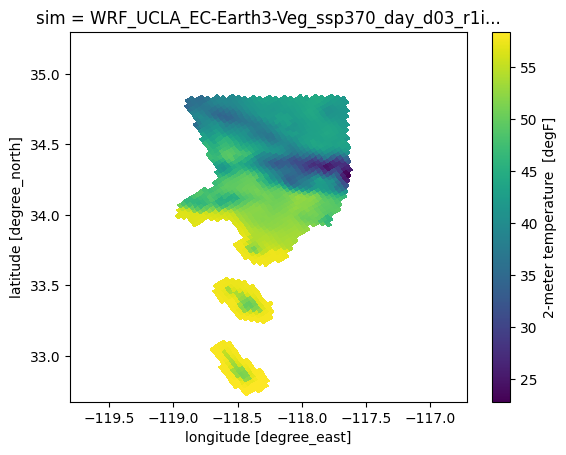

In [51]:
wrf_wl_data.isel(time_delta=0, sim=0, warming_level=0).t2.plot(y="lat", x="lon")

### Processor Example 6: Metric Calculation

For convenience some basic metric calculations have been built in as a processor. The basic options include: `min`, `mean`, `median`, `max`, and `percentiles` and are demonstrated below. 

For advanced analyses 1-in-X calculations have also been included in as a processor.

2025-12-19 10:42:18 - climakitae.new_core.user_interface - INFO - Catalog set to: cadcat
2025-12-19 10:42:18 - climakitae.new_core.user_interface - INFO - Table ID set to: day
2025-12-19 10:42:18 - climakitae.new_core.user_interface - INFO - Grid label set to: d03
2025-12-19 10:42:18 - climakitae.new_core.user_interface - INFO - Variable set to: t2
2025-12-19 10:42:18 - climakitae.new_core.user_interface - INFO - Processes set: 4 operations configured
2025-12-19 10:42:18 - climakitae.new_core.user_interface - INFO - Starting data retrieval with query: {'catalog': 'cadcat', 'installation': UNSET, 'activity_id': UNSET, 'institution_id': UNSET, 'source_id': UNSET, 'experiment_id': UNSET, 'table_id': 'day', 'grid_label': 'd03', 'variable_id': 't2', 'processes': {'warming_level': {'warming_levels': [1.5, 2.0, 3.0]}, 'clip': 'Los Angeles County', 'convert_units': 'degF', 'metric_calc': {'metric': 'min', 'dim': ['time_delta', 'sim']}}}
2025-12-19 10:42:18 - climakitae.new_core.dataset_factory

KeyboardInterrupt: 

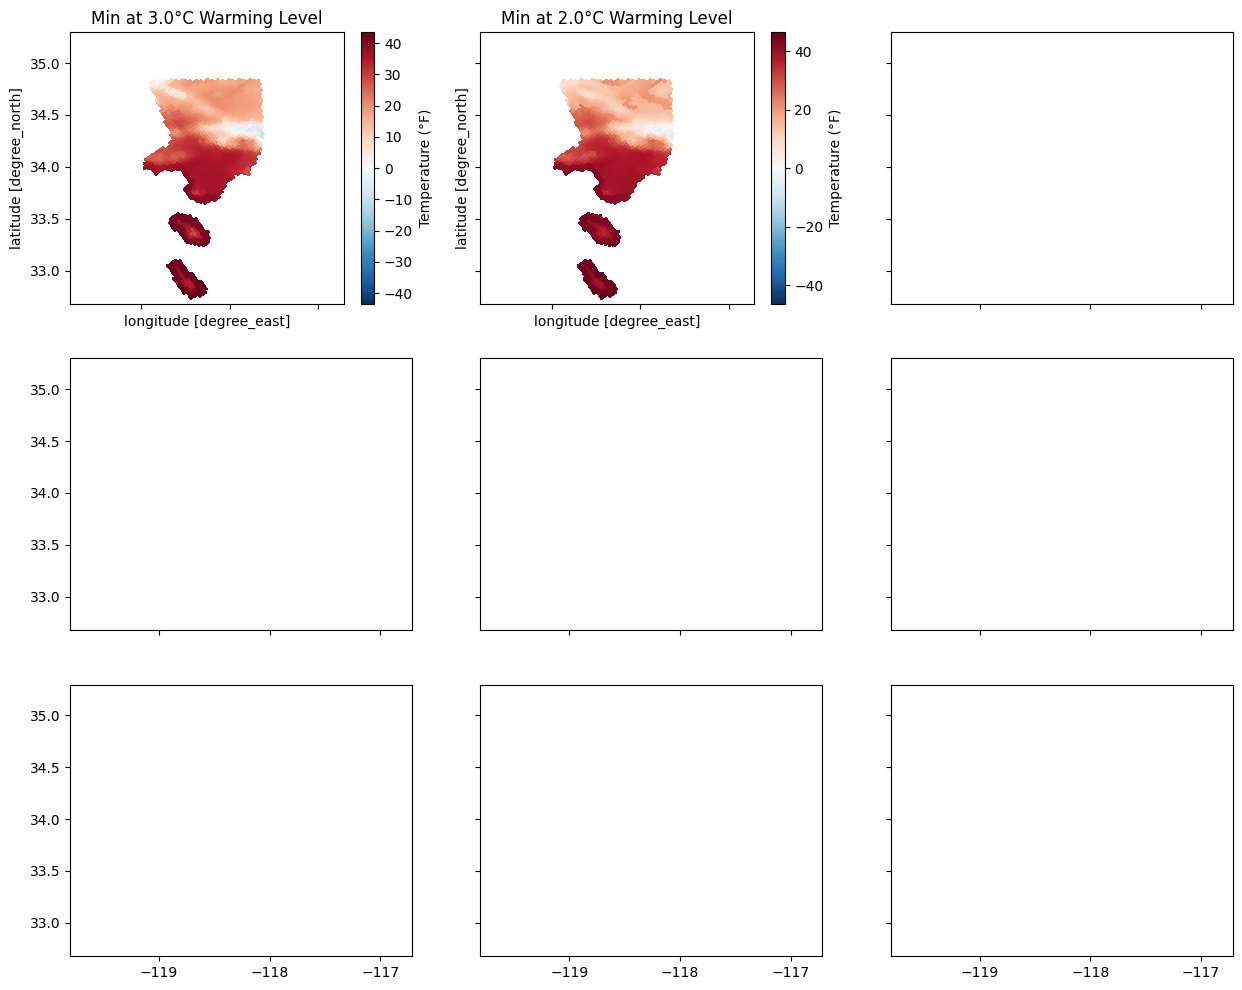

In [52]:
# this cell may take a few minutes to run
# as it is processing and plotting 9 datasets (3 metrics x 3 warming levels)
metrics = ['min', 'mean', 'max']
data = []
for metric in metrics:
    data.append(
        (cd.catalog("cadcat")
        .table_id("day")
        .grid_label("d03")
        .variable("t2")
        .processes({
            "warming_level": {
                "warming_levels": [1.5, 2.0, 3.0],
            },
            "clip": "Los Angeles County",
            "convert_units": "degF",
            "metric_calc": {
                "metric": metric,
                "dim": ["time_delta", "sim"]
                # note: don't average over warming level
            }
        })
        .get())
    )

import matplotlib.pyplot as plt

fig, axes = plt.subplots(3, 3, figsize=(15, 12), sharex=True, sharey=True)

gwls = [1.5, 2.0, 3.0][::-1]  # Reverse for plotting
for i, metric in enumerate(metrics):
    for j, gwl in enumerate(gwls):
        ax = axes[i, j]
        data[i].isel(warming_level=len(gwls) - 1 - j).t2.plot(
            ax=ax,
            y="lat",
            x="lon",
            cbar_kwargs={'label': f'Temperature (°F)'}
        )
        ax.set_title(f'{metric.capitalize()} at {gwl}°C Warming Level')

plt.show()


### Processor Example 7: Export